# PubMed biomedical paper similarity and clustering

This is a jupyter notebook demo of project workflow, the goal is to mine the latent structures with PubMed papers based on their abstracts. The user will provide a query search, the output can provide user:
1. A quick overview of similarites among papers associated with query term
2. Sub-topics associated with query term defined by top ranked key words

In this demo, I will use query term **'((tumor) AND "Cell"[Journal])'** as an example, this returns cancer research papers that publiched on _Cell_(a top journal in biomedical and biological science).

## outline

* PubMed article abstructs fetching using their **Entrez Programming Utilities API**
* document tokenizing and stemming
* transforming the corpus into vector space using **tf-idf**
* calculating cosine distance between each document as a measure of similarity
* using **tSNE** to reduce dimensionality within the corpus
* clustering the documents using the **k-means algorithm**
* plotting the clustering output using **matplotlib** and **mpld3**
* topic modeling using **Latent Dirichlet Allocation (LDA)**  


Below shows the simplified workflow chart
![workflow](ProgramFlow.png) 

## PubMed query and article fetching

Defined some utility functions, query result will be stored as a XML object.

In [1]:
from Bio import Entrez
from Bio.Entrez import efetch
# must install biopython package
# conda install biopython


# returns a list of citation IDs in ['IdList] using esearch utility
def search(query):
    Entrez.email = 'your.email@example.com'
    handle = Entrez.esearch(db='pubmed', 
                            sort='relevance', 
                            retmax='1000', # 1000 most relevant search results
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    handle.close()
    return results


In [2]:
# uses the id_list to query pubmed using efetch utility
def fetch_abstract(id_list):
    ids = ','.join(id_list)
    handle = efetch(db='pubmed', id=ids, retmode='xml') ### this step returns xml object
    #results = Entrez.read(handle) #this step read xml to string
    #return results
    return handle

In [3]:
##returns a xml object, which is taken by the parser as input
def GetQuery(term):
    #arbitrary search term for now (incorporate into front end?)
    results = search(term)
    id_list = results['IdList']
    papers = fetch_abstract(id_list)

    return papers 


Below is an article parser that extracts the article title, first author and abstract text from the retrieved articles.

In [4]:
import xml.etree.cElementTree as ET
import codecs
import sys 

##read file to the tree
def get_root(fname):
    tree = ET.parse(fname)
    return tree.getroot()

##extract ArticleTitle, Abstract,Author information into a list of dictionary (collection)
def get_abstracts(root):
    collection = []
    for article in root.findall("./PubmedArticle/MedlineCitation/Article"): #walk down the XML tree
        data = {
                "ArticleTitle": None,
                "Abstract": None, 
                "Author":None,
        } 
        
        
        ##check the exsitence of those tags for each item, pass if it's None
        check= article.find('./ArticleTitle')==None or article.findall('./Abstract/AbstractText')==None or article.find('./AuthorList/Author/LastName')==None or article.find('./AuthorList/Author/ForeName')==None            
        if check==True:
            pass
        else:
            
            
            ##extract title and author as string
            data["ArticleTitle"] = article.find('./ArticleTitle').text
            data["Author"] = article.find('./AuthorList/Author/LastName').text +' '+ article.find('./AuthorList/Author/ForeName').text
                      
            
            ##deal with multiple segments of AbstractText
            abstract=''
            abtext=article.findall('./Abstract/AbstractText')
            
            
            
            for text in abtext:
                if text.text:
                    abstract=abstract+' '+text.text
            data["Abstract"]=abstract
            
            #add the current entry to collection
            collection.append(data)
    
    return collection

    

##call the helper function, returns data as list of dictionary
def ProccessQuery(filename):
    root = get_root(filename)
    data = get_abstracts(root)
    return data
    

## document tokenizing and stemming
Used a combined stopword list from nltk stop words and [ArrowSmith Project](http://arrowsmith.psych.uic.edu/cgi-bin/arrowsmith_uic/tokenizer.cgi). 
Then each abstract was processed by first removing punctuation and non-alphanumeric characters, followed by stop words removing, then words are stemmed using the Snowball stemmer from the nltk package.

In [5]:
import string
import unicodedata
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

##create two stopword lists
def swansonStoplist():
    with codecs.open('test-query-to-feature/stopwords_swanson.txt','r', encoding='utf-8') as f:
        swanson = f.readlines()
    swanson = [x.strip() for x in swanson] 
    return swanson

def pubmedStoplist():    
    with codecs.open('test-query-to-feature/stopwords_pubmed.txt','r', encoding='utf-8') as f:
        pubmed = f.readlines()
    pubmed = [x.strip() for x in pubmed]     
    return pubmed





##tokenize and stem unicode string, returns a clean unicode string
def TokenStemmer(f):
                
    new_content=word_tokenize(f)
    
    #stemmer and stopwords
    stemmer = SnowballStemmer("english",ignore_stopwords=False)    
    swansonstopWords=stopwords.words('english')+swansonStoplist()
    pubmedstopWords=stopwords.words('english')+pubmedStoplist()
        

    ##iterate through content word list, skip pubmed stop words and do stemming  
    words=''
    for i in new_content:
        if i not in pubmedstopWords:
            new=stemmer.stem(i)
            words=words+' '+new
    return words

In [6]:
def fileparser(term):
    
    xml_object = GetQuery(term)
    sample=ProccessQuery(xml_object)

    feature_list=[]     
    for i in sample:
        if i['Abstract']!=None: #make sure not include missing/bad data point
            content=i['Abstract']
            #translate to string type for punctuation removal
            text_string = content.encode('utf-8').translate(None, string.punctuation)
            #back to unicode
            Utext_string=unicode(text_string, "utf-8")
            #call the TokenStemmer()
            text = TokenStemmer(Utext_string)
            #change again back to ascii string type 
            features=text.encode('ascii','ignore')
            
            ##update value of 'Abstract' to the feature list
            i['Abstract']=features
            feature_list.append(i)
    return feature_list 
            
            
if __name__ == '__main__':
    sample_query1='((tumor) AND "Cell"[Journal])'
    sample_query2='immunotherapy'
    sample_query3='(HDAC) AND immunotherapy' 
    ablist=fileparser(sample_query1)

The output variable _ablist_ from this part is a list of dictionary contains tokenized abstract string, article title and first author name.

In [9]:
print len(ablist)
ablist[0]

987


{'Abstract': ' intratumor heterogen foster tumor evolut key challeng cancer medicin here review data technolog reveal intratumor heterogen cancer type dynam constraint conting inher tumor evolut we emphas macroevolutionari leap involv largescal chromosom alter drive tumor evolut metastasi consid role tumor microenviron engend heterogen drug resist we suggest bold approach drug develop har adapt properti immunemicroenviron limit tumor combin advanc clinic trialdesign improv patient outcom',
 'ArticleTitle': 'Clonal Heterogeneity and Tumor Evolution: Past, Present, and the Future.',
 'Author': 'McGranahan Nicholas'}

## transforming the corpus into vector space using tf-idf, and calculating cosine distance between each document as a measure of similarity

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the abstract list into a tf-idf matrix.

![tf-idf matrix](http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402) 

To get a **Tf-idf matrix**, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. Above is An example of a dtm. 

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document. 

The only parameters I passed was:
**max_df=0.5**: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 50% of the documents it probably cares little meanining, for example, I used 'tumor' as the query term, then many of related terms are probabily appears in most of retrived papers, which are of no help of topic clustering.


In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

corpus = [ab['Abstract'] for ab in ablist]

def get_similarity_matrix(content_as_str):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.5) ## text are stemmed and stop words are removed in previous steps                                                          
    tfidf_matrix = tfidf_vectorizer.fit_transform(content_as_str) #fit the vectorizer to abtracts
    similarity_matrix = cosine_similarity(tfidf_matrix)
    terms = tfidf_vectorizer.get_feature_names()
    return (similarity_matrix, tfidf_matrix,terms)

(similarity_matrix, tfidf_matrix,terms) = get_similarity_matrix(corpus)

**similarity** is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each abstract among the abstracts). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more abstracts.   

**terms** is just a list of the features used in the tf-idf matrix. This is a vocabulary

In [171]:
print similarity_matrix.shape
print tfidf_matrix.shape
print len(terms)

(987, 987)
(987, 8243)
8243


To get a sense of the document similarity, I took first 30 documents and plot the similarity matrix(square root transformed to better visualize) as a heatmap, it is obvious that this is a symmetric matrix and some documents similarites are higher than other pairs.

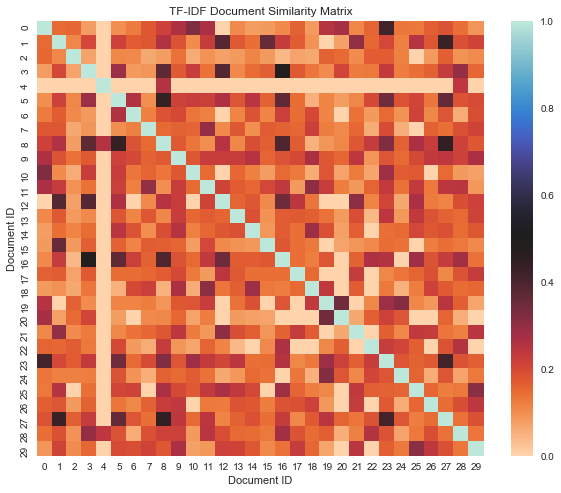

In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
#%pylab inline
df = pd.DataFrame(similarity_matrix)
df1 = df.iloc[0:30,0:30]
df2=df1.apply(np.sqrt) #sqrt transform to make the data better scaled and the difference easier to see

figure(figsize=(10, 8))
heatmap=sns.heatmap(df2,cmap='icefire_r')
heatmap.set(xlabel='Document ID', ylabel='Document ID',title='TF-IDF Document Similarity Matrix')
plt.show()

## Using tSNE to reduce dimensionality within the corpus

At this point, I would like to see if those documents will be clustered in groups when embedded in 2D map, it can provide me some idea about how many topics to set in the following analysis. Also because this is unsupervised learning, this preliminary embedded visualization will help me tune parameter in tfidf_vectorizer step.

I compared MDS([multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling)) and tSNE([t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)), the latter looks much better.

In [173]:
from sklearn.manifold import MDS
MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

mds_pos = mds.fit_transform(similarity_matrix)  # shape (n_components, n_samples)
#pos is the x and y position of each data point
#xs, ys = pos[:, 0], pos[:, 1]


In [174]:
#For high-dimensional sparse data it is helpful to first reduce the dimensions to 50 dimensions 
#with TruncatedSVD and then perform t-SNE. This will usually improve the visualization.
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=50, random_state=1).fit_transform(similarity_matrix)
from sklearn.manifold import TSNE
tsne_pos = TSNE(n_components=2, perplexity=40, verbose=2,random_state=1).fit_transform(X_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 987 samples in 0.002s...
[t-SNE] Computed neighbors for 987 samples in 0.152s...
[t-SNE] Computed conditional probabilities for sample 987 / 987
[t-SNE] Mean sigma: 0.277740
[t-SNE] Computed conditional probabilities in 0.066s
[t-SNE] Iteration 50: error = 70.8684845, gradient norm = 0.2686500 (50 iterations in 2.663s)
[t-SNE] Iteration 100: error = 71.1379013, gradient norm = 0.2621521 (50 iterations in 2.481s)
[t-SNE] Iteration 150: error = 71.3709183, gradient norm = 0.2410395 (50 iterations in 2.590s)
[t-SNE] Iteration 200: error = 71.7240677, gradient norm = 0.2684314 (50 iterations in 2.493s)
[t-SNE] Iteration 250: error = 72.1731644, gradient norm = 0.2521621 (50 iterations in 2.317s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.173164
[t-SNE] Iteration 300: error = 1.3289351, gradient norm = 0.0021786 (50 iterations in 2.198s)
[t-SNE] Iteration 350: error = 1.2558546, gradient norm = 0.0005348 

Comparison of 2d mapping between MDS and tSNE. 

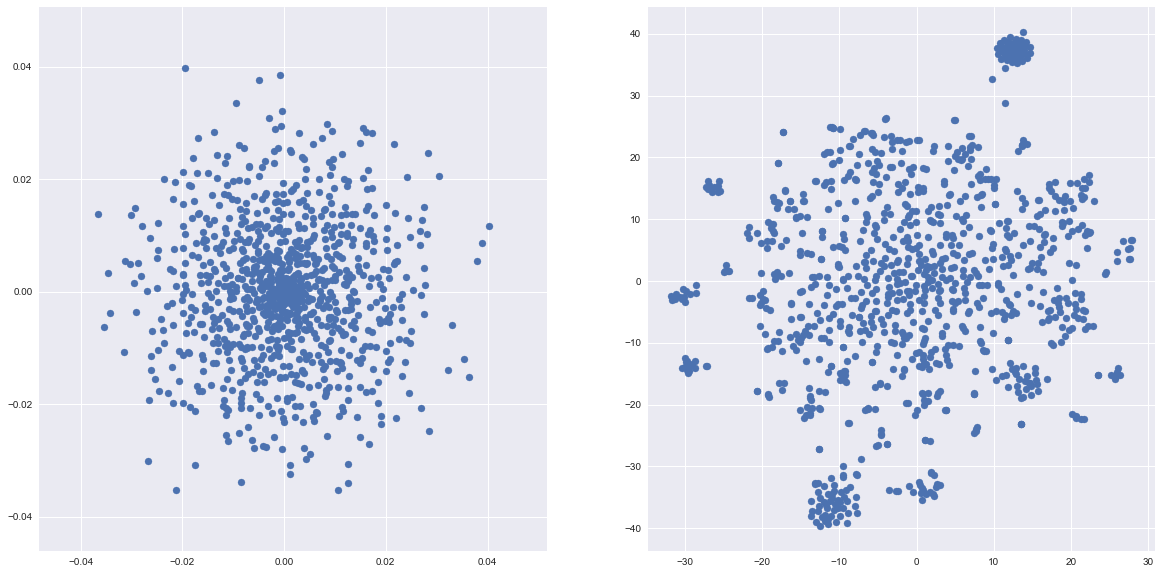

In [175]:
figure(figsize=(20, 10))
subplot(121)
scatter(mds_pos[:, 0], mds_pos[:, 1])
subplot(122)
scatter(tsne_pos[:, 0], tsne_pos[:, 1])

## Clustering the documents using the k-means algorithm

Using the **tf-idf matrix** obtained before, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (after a few experiments I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [410]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [411]:
from sklearn.externals import joblib
#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle
#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

Organize the clustered paper in a pandas dataframe

In [412]:
cluster_list=[]
for a in range(len(clusters)):
    papers={}
    papers['title']=ablist[a]['ArticleTitle']
    papers['author']=ablist[a]['Author']
    papers['cluster']=clusters[a]
    cluster_list.append(papers)
frame=pd.DataFrame(cluster_list)
frame['x']=tsne_pos[:,0] #use tsne embedding as visualization
frame['y']=tsne_pos[:,1]

In [413]:
frame.head()

,author,cluster,title,x,y
0,McGranahan Nicholas,2,Clonal Heterogeneity and Tumor Evolution: Past...,9.001602,18.058207
1,Chang Chih-Hao,4,Metabolic Competition in the Tumor Microenviro...,15.530340,-16.705420
2,Sturm Dominik,3,New Brain Tumor Entities Emerge from Molecular...,5.804302,10.078648
3,DiLillo David J,2,Differential Fc-Receptor Engagement Drives an ...,18.874430,8.891296
4,Overacre-Delgoffe Abigail E,3,Interferon-γ Drives T,13.785485,40.297417


In [414]:
frame['cluster'].value_counts() 

3    476
4    271
2    150
1     65
0     25
Name: cluster, dtype: int64

Here is some indexing and sorting on each cluster to identify which are the top n (I chose n=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster. I also printed 5 papers from each cluster just to see if I can tell from the article title wether this clustering makes sense (because I didn't use article title as tokens). 

The K-means clustering result is interesting:
* The 5 topics quite represents the major cancer research sub-domains, such as p53 protein in apoptosis induction, because p53 is mutated in large percentage of cancer cases and is currently not druggable, therefore it is an active research topic. A second example is Immunotherapy, unlike p53, immunotherapy has been making major progress towards clinical application, that is why words like patient, response are associated with this topic.
* The paper titles also quite matches the topic they are clustered into, however papers published in top-tier peer-reviewed journal like _Cell_ are usually very comprehensive, often use multiple strategies to evaluate more than one scientific hypotheses. Therefore, the topic category a paper belongs to does not necessarily always means it is similar to other papers in the same cluster.



In [420]:
from __future__ import print_function
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

topic_lists=[]##make a key word list for each topic to use as the visualization legend 
for i in range(num_clusters):
    topic={}
    #topic['topic']=i
    key_word_list=[]
    print("Cluster %d topic words:" % i, end='')
    for ind in order_centroids[i, :6]: #top 6 words
        key_word_list.append(terms[ind].encode('utf-8', 'ignore'))
        print(' %s' % terms[ind].encode('utf-8', 'ignore'), end=',')
    topic[i]=key_word_list
    print() #add whitespace
    print() #add whitespace
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[frame['cluster'] == i][:5]['title']:
        print()
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    topic_lists.append(topic)
    
print()



Top terms per cluster:

Cluster 0 topic words: pten, telomer, telomeras, alt, chromosom, suppressor,

Cluster 0 titles:
 Nuclear PTEN regulates the APC-CDH1 tumor-suppressive complex in a phosphatase-independent manner.,
 Tenets of PTEN tumor suppression.,
 Ubiquitination regulates PTEN nuclear import and tumor suppression.,
 In vivo identification of tumor- suppressive PTEN ceRNAs in an oncogenic BRAF-induced mouse model of melanoma.,
 Telomerase reactivation following telomere dysfunction yields murine prostate tumors with bone metastases.,

Cluster 1 topic words: p53, suppressor, activ, apoptosi, function, respons,

Cluster 1 titles:
 Autophagy-mediated tumor promotion.,
 Tumor suppression in the absence of p53-mediated cell-cycle arrest, apoptosis, and senescence.,
 Distinct p53 transcriptional programs dictate acute DNA-damage responses and tumor suppression.,
 p53-dependent Nestin regulation links tumor suppression to cellular plasticity in liver cancer.,
 Putting p53 in Context.

## Plotting the clustering output using matplotlib and mpld3

In this section, I visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js). 

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.  
Next, I plotted the documents colored by cluster using matplotlib. Because there are too many points, it is difficult to label each document information, this plot is to give an overview of clusters and their 2d layout. The best visualization for reader would be a browser based/javascript interactive plot created by D3.js. [mpld3](https://mpld3.github.io) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.


In [421]:
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#d8a61e'}
colors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
        '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', 
        '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
cluster_colors = {}
for i in range(len(topic_lists)):
    cluster_colors[i] = colors[i]
cluster_names = {} ## will be used as plot legend
for i in range(len(topic_lists)):
    cluster_names[i] = topic_lists[i].values()[0]

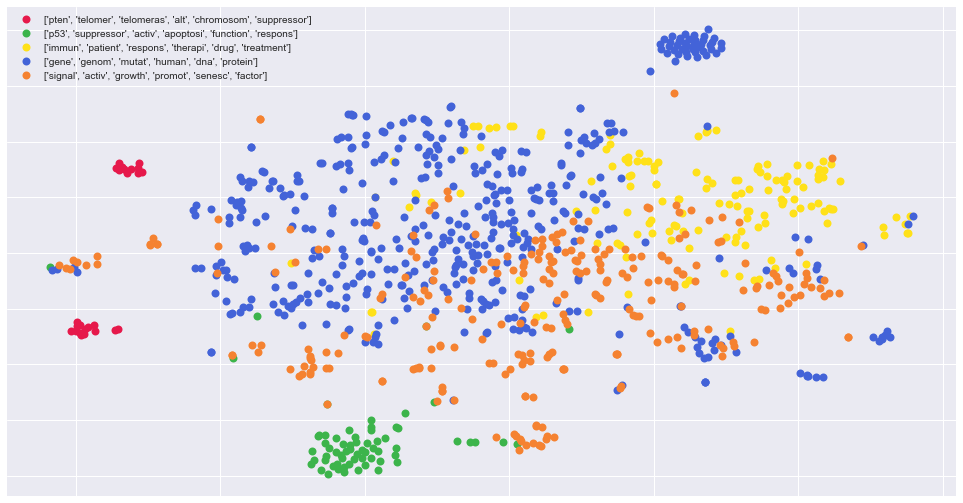

In [419]:
groups = frame.groupby('cluster')
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#uncomment below to add label in x,y position with the label as the article title
#for i in range(len(frame)):
#    ax.text(frame.iloc[i]['x'], frame.iloc[i]['y'], frame.iloc[i]['author'], size=8)  

    
    
plt.show() #show the plot


In [422]:
plt.close()

In [423]:
import mpld3
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}



In [431]:
#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -100px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,10)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

## Topic modeling using Latent Dirichlet Allocation (LDA)

This section focuses on using **Latent Dirichlet Allocation (LDA)** to learn yet more about the hidden structure within the retrieved papers. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics.For my implementaiton of LDA, I use the **Gensim** pacakage. 

In [470]:
split_corpus = []
for item in corpus:
    split_item = item.split()
    split_corpus.append(split_item)

In [471]:
from gensim import corpora, models, similarities 
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(split_corpus)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_above=0.5)
#convert the dictionary to a bag of words corpus for reference
lda_corpus = [dictionary.doc2bow(text) for text in split_corpus]


In [472]:
lda = models.LdaModel(lda_corpus, num_topics=5, 
                            id2word=dictionary, 
                            update_every=0, 
                            chunksize=10000, 
                            passes=200)

Each topic has a set of words that defines it, along with a certain probability.

In [473]:
lda.show_topics()

[(0,
  u'0.019*"immun" + 0.016*"t" + 0.013*"respons" + 0.013*"we" + 0.012*"patient" + 0.011*"therapi" + 0.011*"clinic" + 0.009*"develop" + 0.009*"drug" + 0.009*"diseas"'),
 (1,
  u'0.027*"gene" + 0.026*"mutat" + 0.021*"genom" + 0.013*"dna" + 0.012*"chromosom" + 0.011*"we" + 0.010*"pten" + 0.009*"human" + 0.009*"express" + 0.008*"identifi"'),
 (2,
  u'0.022*"p53" + 0.019*"activ" + 0.012*"protein" + 0.011*"function" + 0.011*"respons" + 0.009*"apoptosi" + 0.009*"regul" + 0.009*"the" + 0.008*"stress" + 0.008*"transcript"'),
 (3,
  u'0.021*"activ" + 0.015*"inhibit" + 0.014*"signal" + 0.013*"pathway" + 0.013*"regul" + 0.011*"target" + 0.011*"growth" + 0.011*"protein" + 0.010*"metabol" + 0.010*"express"'),
 (4,
  u'0.015*"stem" + 0.011*"metastasi" + 0.010*"express" + 0.010*"signal" + 0.009*"breast" + 0.009*"differenti" + 0.009*"we" + 0.008*"metastat" + 0.008*"invas" + 0.008*"model"')]


Here, I convert the topics into just a list of the top 20 words in each topic. You can see a similar breakdown of topics as I identified using k-means.

In [474]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for i in range(len(topics_matrix)):
    array = np.array(topics_matrix[i][1])
    topic_keyword=[]
    for word in array[:,0]:
        word = word.encode('ascii','ignore')
        topic_keyword.append(word)
    print(topic_keyword)
    print()
    


['immun', 't', 'respons', 'we', 'patient', 'therapi', 'clinic', 'develop', 'drug', 'diseas', 'identifi', 'target', 'resist', 'genet', 'therapeut', 'provid', 'treatment', 'combin', 'studi', 'data']

['gene', 'mutat', 'genom', 'dna', 'chromosom', 'we', 'pten', 'human', 'express', 'identifi', 'the', 'alter', 'transcript', 'associ', 'function', 'loss', 'number', 'suggest', 'chromatin', 'suppressor']

['p53', 'activ', 'protein', 'function', 'respons', 'apoptosi', 'regul', 'the', 'stress', 'transcript', 'signal', 'mechan', 'dna', 'gene', 'mice', 'complex', 'pathway', 'factor', 'induc', 'express']

['activ', 'inhibit', 'signal', 'pathway', 'regul', 'target', 'growth', 'protein', 'metabol', 'express', 'transcript', 'human', 'function', 'oncogen', 'kinas', 'gene', 'the', 'we', 'here', 'effect']

['stem', 'metastasi', 'express', 'signal', 'breast', 'differenti', 'we', 'metastat', 'invas', 'model', 'progress', 'tissu', 'promot', 'growth', 'in', 'develop', 'malign', 'epitheli', 'human', 'microenvi

## Conclusions

1. Three approaches(tf-idf similarity with tSNE 2d embedding, k-mean and LDA) were used in this project to analysis relationships and topics of PubMed articles retrieved using a search term. The results are quite reasonable and comparable.
2. Shortage of this analysis is that as an unsupervised learning, it is hard to find large number of labeled training data to refine the model, therefore it is difficult to define an objective evaluation approach for this task. Here I tried to compare 3 different approaches and compare their performance as a way to evaluation, I also subjectively judge the results based on my biomedical domain knowledge. Another solution would be to develop it into a web app, user involvement can be used as a training strategy.
3. The application potential of this pipline is great, user can not only utilize it to get an quick overview and understanding of studies in certain area that he or she may not be familiar with. Another use case would be to generate this type of map for scientific conference papers, so attendees will quickly know who are doing similar research, this may facilitate collaboration among scientists. 

## Reference

1. [t-SNE in scikit learn, Alexander Fabisch](http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html)
2. [Document Clustering with Python, Brandon Rose](http://brandonrose.org/clustering)